## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [4]:
# BMW here serves as a benchmark
raw_data = yfinance.download(tickers='VOW3.DE, PAH3.DE, BMW.DE', interval='1d',group_by = 'ticker', 
                   auto_adjust = True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [5]:
df = raw_data.copy()

## Defining Key Dates

In [6]:
# Starting Date
start_date = '2009-04-05'
# First Official Announcement - 49.9%
ann_date = '2009-12-09'
# Second Official Announcement - 51.1%
ann_date2 = '2012-07-05'
#Ending Date
end_date = '2014-01-01'
# Dieselgate
d_gate = '2015-09-20'

In [10]:
df['VOW3.DE']

,Open,High,Low,Close,Volume
Date,,,,,
1996-11-08,NaN,NaN,NaN,NaN,NaN
1996-11-11,NaN,NaN,NaN,NaN,NaN
1996-11-12,NaN,NaN,NaN,NaN,NaN
1996-11-13,NaN,NaN,NaN,NaN,NaN
1996-11-14,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-03-09,197.580002,198.000000,190.100006,192.220001,1679220.0
2021-03-10,192.000000,196.059998,190.940002,196.020004,1552220.0
2021-03-11,197.399994,197.660004,191.500000,192.039993,1563321.0


## Pre-processing the Data

In [15]:
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df['ret_vol'].apply(np.square)
df['sq_por'] = np.square(df['ret_por'])
df['sq_bmw'] = df['ret_bmw'].mul(df['ret_bmw'])

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [16]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method = 'bfill')

In [18]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

## Plotting the Prices

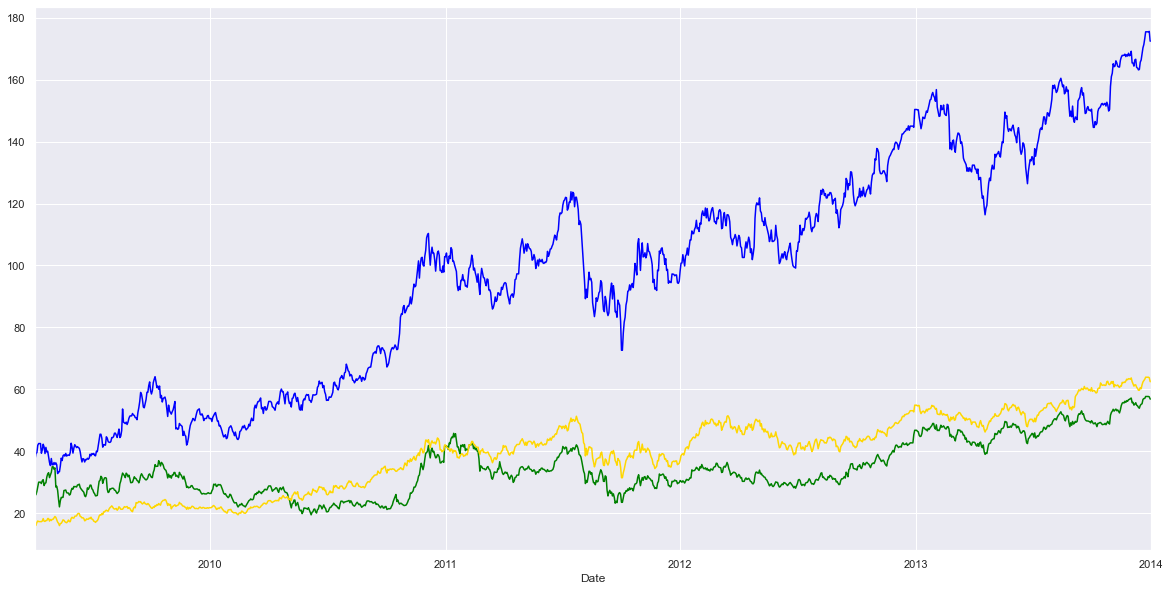

In [21]:
df['vol'][start_date:end_date].plot(figsize=(20,10), color='blue')
df['por'][start_date:end_date].plot(color='green')
df['bmw'][start_date:end_date].plot(color='gold')
plt.show()

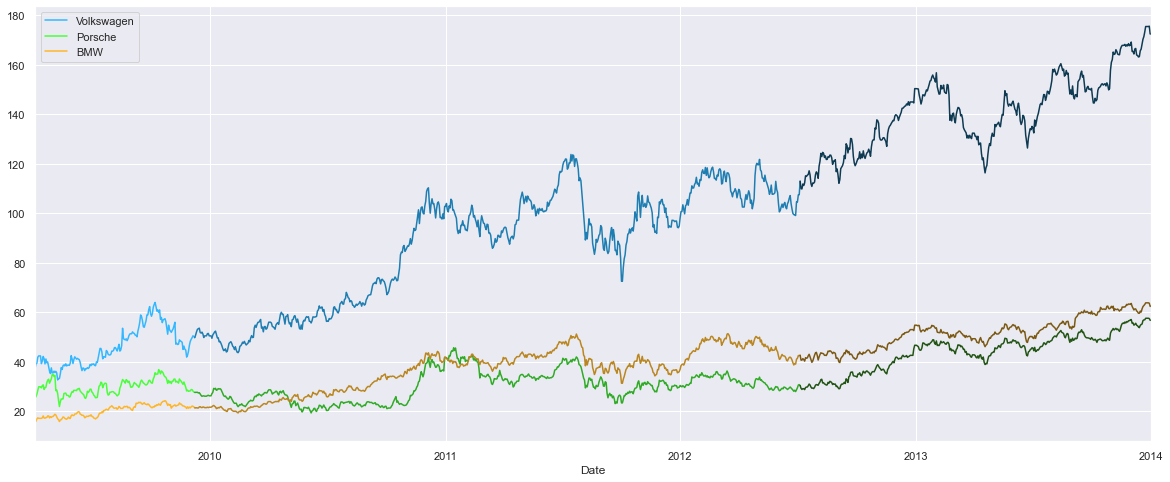

In [23]:
#color = "#33B8FF"
#color = "#49FF3A"
#color = "#FEB628"

#color = "#1E7EB2"
#color = "#2FAB25"
#color = "#BA861F"

#color = "#0E3A52"
#color = "#225414"
#color = "#7C5913"

df['vol'][start_date:ann_date].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_date].plot(color = "#49FF3A")
df['bmw'][start_date:ann_date].plot(color = "#FEB628")

df['vol'][ann_date:ann_date2].plot(color = "#1E7EB2")
df['por'][ann_date:ann_date2].plot(color = "#2FAB25")
df['bmw'][ann_date:ann_date2].plot(color = "#BA861F")

df['vol'][ann_date2:end_date].plot(color = "#0E3A52")
df['por'][ann_date2:end_date].plot(color = "#225414")
df['bmw'][ann_date2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])

plt.show()

## Correlation
calculate the correlation between periods to see if there're special relationship in certain period

In [24]:
# Volkswagen moves similar to the market benchmark
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8359547164164511
Volkswagen and BMW correlation: 	0.9799378249373728
Porsche and BMW correlation: 		0.8052157916911926


In [29]:
# Porsche and BMW's proces weren't too similar before the buyout
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_date].corr(df['por'][start_date:ann_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_date].corr(df['bmw'][start_date:ann_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_date].corr(df['bmw'][start_date:ann_date])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633584449543652
Volkswagen and BMW correlation: 	0.8427607817493329
Porsche and BMW correlation: 		0.6095038934500048


In [30]:
print('Correlation among manufacturers from ' + str(ann_date) + ' to ' + str(ann_date2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_date:ann_date2].corr(df['por'][ann_date:ann_date2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_date:ann_date2].corr(df['bmw'][ann_date:ann_date2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_date:ann_date2].corr(df['bmw'][ann_date:ann_date2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428267849870892
Volkswagen and BMW correlation: 	0.9795942977599622
Porsche and BMW correlation: 		0.7042723078716631


In [31]:
# after the whole buyout, we first see Volkswagen and Porsche's prices highly correlated, mean that they're the same entity
print('Correlation among manufacturers from ' + str(ann_date2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_date2:end_date].corr(df['por'][ann_date2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_date2:end_date].corr(df['bmw'][ann_date2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_date2:end_date].corr(df['bmw'][ann_date2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237174785849
Volkswagen and BMW correlation: 	0.9284447310955933
Porsche and BMW correlation: 		0.9494111736594023


In [32]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2021-03-15 00:00:00

Volkswagen and Porsche correlation: 	0.9632032212678389
Volkswagen and BMW correlation: 	0.5349404857359624
Porsche and BMW correlation: 		0.5126659049493555


## Best Fitting Models

### For Volkswagen

In [33]:
mod_vol_pre = auto_arima(df['vol'][start_date:ann_date], exogenous = df[['por', 'bmw']][start_date:ann_date], 
                         m=5, max_p=5, max_q=5)
mod_vol_btn = auto_arima(df['vol'][ann_date:ann_date2], exogenous = df[['por', 'bmw']][ann_date:ann_date2], 
                         m=5, max_p=5, max_q=5)
mod_vol_btn = auto_arima(df['vol'][ann_date2:end_date], exogenous = df[['por', 'bmw']][ann_date2:end_date], 
                         m=5, max_p=5, max_q=5)

In [34]:
# AR(1) with 2 exogenous variables is the best fit
mod_vol_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -327.180
Date:                Tue, 16 Mar 2021   AIC                            664.360
Time:                        00:33:06   BIC                            680.269
Sample:                    04-06-2009   HQIC                           670.811
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7404      0.458      1.618      0.106      -0.157       1.637
por            0.3997      0.096      4.169      0.000       0.212       0.588
bmw            0.6763      0.321      2.107      0.035       0.047       1.305
ar.L1          0.9633      0.020     48.670      0.000       0.925       1.002
sigma2         2.2785      0.155     14.718      0.000       1.975       2.582
===================================================================================
Ljung-Box (Q):                       38.25   Jarque-Bera (JB):               166.03
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Integrated (1) with 2 exogenous variables is the best fit
mod_vol_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Tue, 16 Mar 2021   AIC                           1239.872
Time:                        00:33:09   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8382      0.089      9.381      0.000       0.663       1.013
sigma2         1.3966      0.068     20.461      0.000       1.263       1.530
===================================================================================
Ljung-Box (Q):                       28.07   Jarque-Bera (JB):               103.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Integrated (1) with 2 exogenous variables is the best fit
mod_vol_btn .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -616.936
Date:                Tue, 16 Mar 2021   AIC                           1239.872
Time:                        00:33:11   BIC                           1251.762
Sample:                    07-05-2012   HQIC                          1244.586
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7180      0.057     30.369      0.000       1.607       1.829
bmw            0.8382      0.089      9.381      0.000       0.663       1.013
sigma2         1.3966      0.068     20.461      0.000       1.263       1.530
===================================================================================
Ljung-Box (Q):                       28.07   Jarque-Bera (JB):               103.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [37]:
mod_por_pre = auto_arima(df['por'][start_date:ann_date], exogenous = df[['vol', 'bmw']][start_date:ann_date], 
                         m=5, max_p=5, max_q=5)
mod_por_btn = auto_arima(df['por'][ann_date:ann_date2], exogenous = df[['vol', 'bmw']][ann_date:ann_date2], 
                         m=5, max_p=5, max_q=5)
mod_por_btn = auto_arima(df['por'][ann_date2:end_date], exogenous = df[['vol', 'bmw']][ann_date2:end_date], 
                         m=5, max_p=5, max_q=5)

In [38]:
# AR(2) with 2 exogenous variables is the best fit
mod_por_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -230.105
Date:                Tue, 16 Mar 2021   AIC                            472.209
Time:                        00:40:12   BIC                            491.300
Sample:                    04-06-2009   HQIC                           479.951
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5897      0.385      1.533      0.125      -0.164       1.344
vol            0.1151      0.053      2.157      0.031       0.011       0.220
bmw            0.8626      0.155      5.557      0.000       0.558       1.167
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.7682      0.054     14.098      0.000       0.661       0.875
===================================================================================
Ljung-Box (Q):                       26.01   Jarque-Bera (JB):               559.36
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
# These trends are affected more by current events rather than pre-existing patterns
mod_por_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -219.646
Date:                             Tue, 16 Mar 2021   AIC                            447.292
Time:                                     00:40:12   BIC                            463.146
Sample:                                 07-05-2012   HQIC                           453.577
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.876      0.000       0.196       0.248
bmw            0.2450      0.041      6.036      0.000       0.165       0.325
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1811      0.007     27.851      0.000       0.168       0.194
===================================================================================
Ljung-Box (Q):                       34.49   Jarque-Bera (JB):               613.59
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
mod_por_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -219.646
Date:                             Tue, 16 Mar 2021   AIC                            447.292
Time:                                     00:40:13   BIC                            463.146
Sample:                                 07-05-2012   HQIC                           453.577
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2220      0.013     16.876      0.000       0.196       0.248
bmw            0.2450      0.041      6.036      0.000       0.165       0.325
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1811      0.007     27.851      0.000       0.168       0.194
===================================================================================
Ljung-Box (Q):                       34.49   Jarque-Bera (JB):               613.59
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions for the Future

### For Porsche

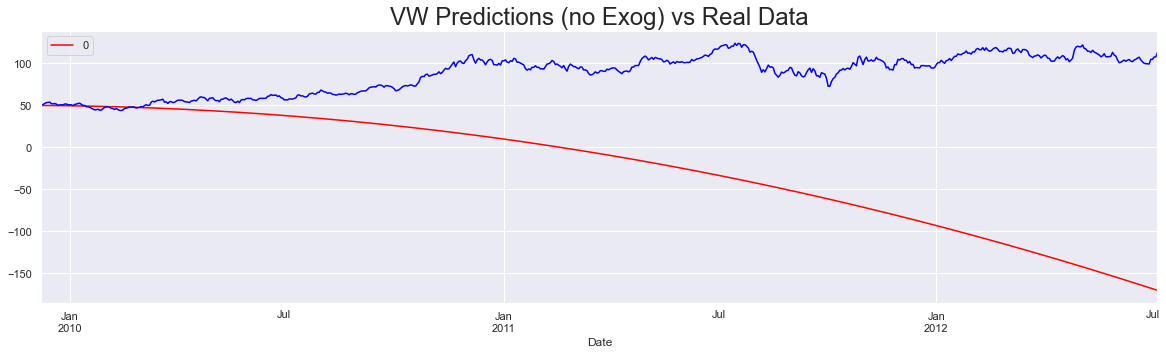

In [45]:
# forecasted price going down than zero, wrong!
por_pre_pred = auto_arima(df['vol'][start_date:ann_date], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_por_pred = pd.DataFrame(por_pre_pred.predict(n_periods = len(df['vol'][ann_date:ann_date2])), 
                           index = df['vol'][ann_date:ann_date2].index)

df_por_pred[ann_date:ann_date2].plot(figsize=(20,5), color='red')
df.vol[ann_date:ann_date2].plot(color='blue')
plt.title("VW Predictions (no Exog) vs Real Data", size = 24)
plt.show()

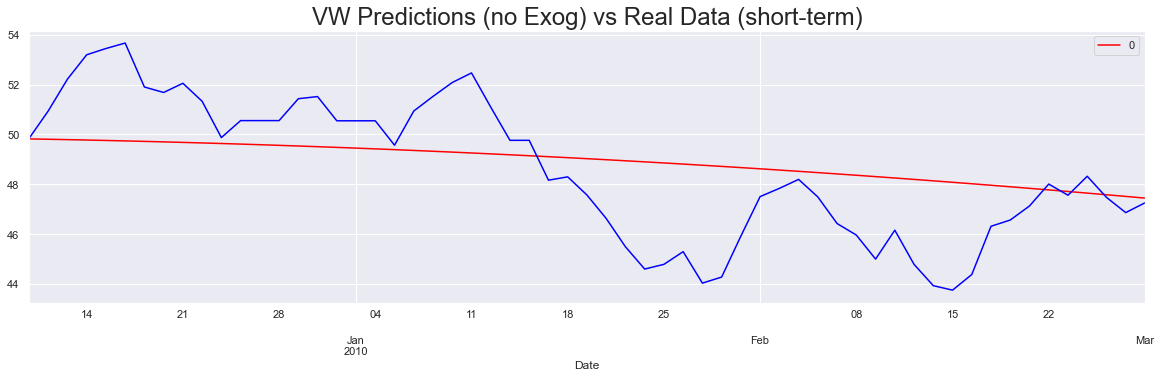

In [46]:
df_por_pred[ann_date:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[ann_date:'2010-03-01'].plot(color='blue')
plt.title("VW Predictions (no Exog) vs Real Data (short-term)", size = 24)
plt.show()

### For Volkswagen

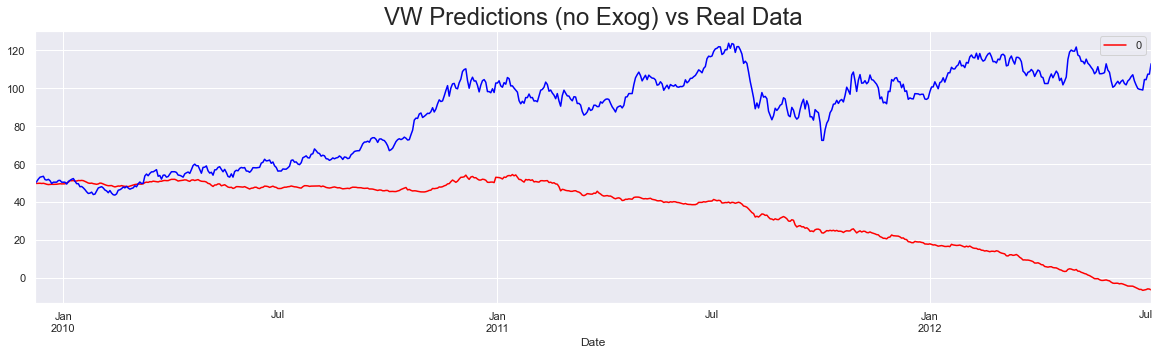

In [52]:
# exogenous is expecting 2D array that you need to input df[['por']]
vol_pre_pred = auto_arima(df['vol'][start_date:ann_date], exogenous=df[['por']][start_date:ann_date].values,
                          m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_por_pred = pd.DataFrame(vol_pre_pred.predict(n_periods = len(df['vol'][ann_date:ann_date2]), 
                        exogenous=df[['por']][ann_date:ann_date2]).reshape(-1,1), index = df['vol'][ann_date:ann_date2].index)

df_por_pred[ann_date:ann_date2].plot(figsize=(20,5), color='red')
df.vol[ann_date:ann_date2].plot(color='blue')
plt.title("VW Predictions (with POR as exog) vs Real Data", size = 24)
plt.show()

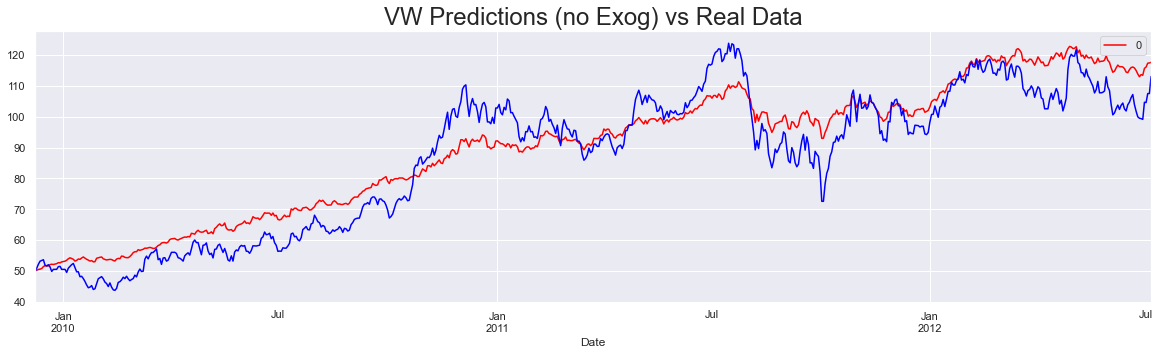

In [53]:
vol_pre_pred = auto_arima(df['vol'][start_date:ann_date], exogenous=df[['bmw']][start_date:ann_date].values,
                          m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_por_pred = pd.DataFrame(vol_pre_pred.predict(n_periods = len(df['vol'][ann_date:ann_date2]), 
                        exogenous=df[['bmw']][ann_date:ann_date2]).reshape(-1,1), index = df['vol'][ann_date:ann_date2].index)

df_por_pred[ann_date:ann_date2].plot(figsize=(20,5), color='red')
df.vol[ann_date:ann_date2].plot(color='blue')
plt.title("VW Predictions (with market as exog) vs Real Data", size = 24)
plt.show()

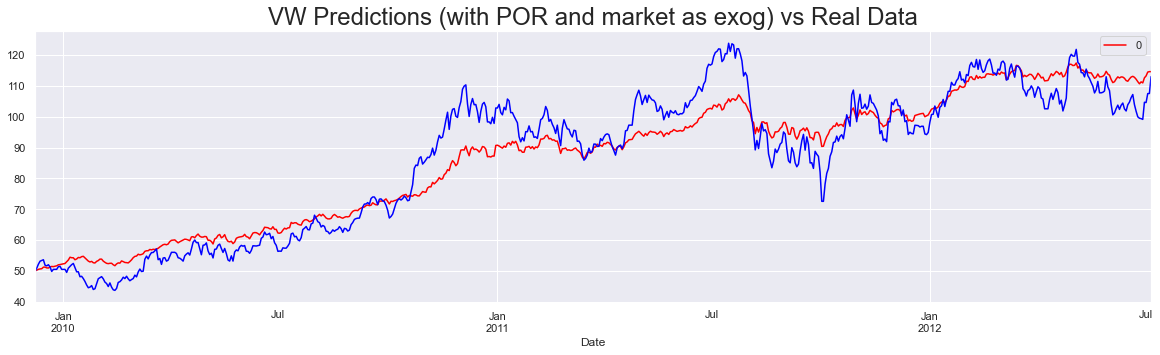

In [54]:
vol_pre_pred = auto_arima(df['vol'][start_date:ann_date], exogenous=df[['por','bmw']][start_date:ann_date].values,
                          m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

df_por_pred = pd.DataFrame(vol_pre_pred.predict(n_periods = len(df['vol'][ann_date:ann_date2]), 
                        exogenous=df[['por','bmw']][ann_date:ann_date2]).reshape(-1,1), index = df['vol'][ann_date:ann_date2].index)

df_por_pred[ann_date:ann_date2].plot(figsize=(20,5), color='red')
df.vol[ann_date:ann_date2].plot(color='blue')
plt.title("VW Predictions (with POR and market as exog) vs Real Data", size = 24)
plt.show()

## Volatility

### Volatility of VW for Each Period

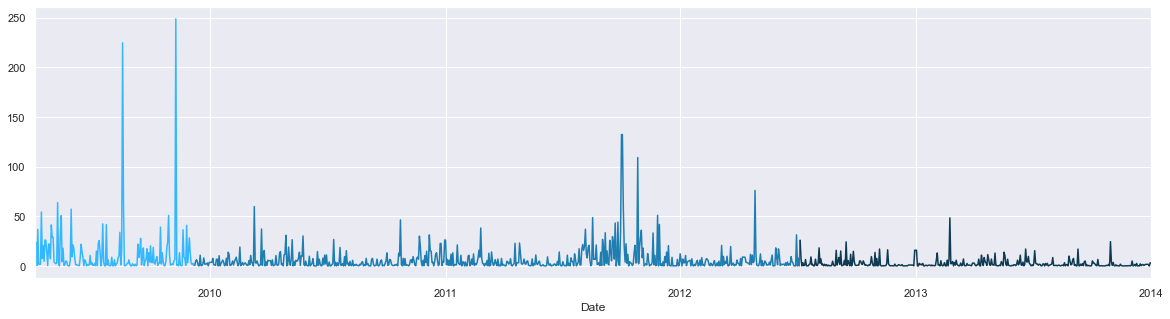

In [55]:
df['sq_vol'][start_date:ann_date].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_date:ann_date2].plot(color = "#1E7EB2")
df['sq_vol'][ann_date2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatility Trends for Each Period

In [56]:
garch_pre = arch_model(df.ret_vol[start_date:ann_date], vol='GARCH', mean='Constant', p=1, q=1)
gar_re_pre = garch_pre.fit(update_freq=5)

garch_btn = arch_model(df.ret_vol[ann_date:ann_date2], vol='GARCH', mean='Constant', p=1, q=1)
gar_re_btn = garch_btn.fit(update_freq=5)

garch_post = arch_model(df.ret_vol[ann_date2:end_date], vol='GARCH', mean='Constant', p=1, q=1)
gar_re_post = garch_post.fit(update_freq=5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.7775372006258
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.00317765057133
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.9905156457213
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9905155934316
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.753602749299
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7316714622107
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7316714609651
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5624799318961
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5581359827627
            Iterations: 7
            F

In [57]:
gar_re_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.981
Method:            Maximum Likelihood   BIC:                           970.708
                                        No. Observations:                  178
Date:                Tue, Mar 16 2021   Df Residuals:                      177
Time:                        01:07:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1570      0.266      0.589      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6196      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.194e-02      1.675  9.399e-02 [-2.623e-02,  0.334]
beta[1]    6.7760e-14      0.349  1.940e-13      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [58]:
gar_re_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Tue, Mar 16 2021   Df Residuals:                      671
Time:                        01:07:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.301e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.884      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [59]:
gar_re_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Tue, Mar 16 2021   Df Residuals:                      389
Time:                        01:07:22   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""